In [5]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def set_seed(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_seed(0)

Using device: cuda


In [10]:
# Heston parameters
S0     = 100.0
v0     = 0.04
r      = 0.0
kappa  = 1.5
theta  = 0.04
sigma_v = 0.3
rho    = -0.7

T_final   = 1.0
n_steps   = 200
dt        = T_final / n_steps

# DSM / score model parameters
sigma_min = 0.02
sigma_max = 0.5
hidden_dim = 128
batch_size = 256
n_epochs   = 200
lr         = 1e-3

# sampling parameters
n_langevin_steps_per_sigma = 60
n_sigmas  = 10
langevin_eps = 0.01


In [11]:
def simulate_heston_paths(
    n_paths,
    n_steps,
    T,
    S0,
    v0,
    r,
    kappa,
    theta,
    sigma_v,
    rho,
):
    dt = T / n_steps
    X = torch.zeros(n_paths, n_steps + 1)  # log-price
    V = torch.zeros(n_paths, n_steps + 1)  # variance

    X[:, 0] = math.log(S0)
    V[:, 0] = v0

    for i in range(n_steps):
        z1 = torch.randn(n_paths)
        z2 = torch.randn(n_paths)

        dW1 = math.sqrt(dt) * z1
        dW2 = rho * dW1 + math.sqrt(1 - rho**2) * math.sqrt(dt) * z2

        v = torch.clamp(V[:, i], min=0.0)
        V[:, i+1] = torch.clamp(
            v + kappa * (theta - v) * dt + sigma_v * torch.sqrt(v) * dW2,
            min=1e-8
        )

        X[:, i+1] = X[:, i] + (r - 0.5 * v) * dt + torch.sqrt(v) * dW1

    return X, V   # shapes: (n_paths, n_steps+1)


class HestonScoreDataset(Dataset):

    def __init__(self, X_paths, V_paths, t_indices, T_total):
        super().__init__()
        self.X_paths = X_paths
        self.V_paths = V_paths
        self.t_indices = t_indices
        self.T_total = T_total

        n_paths, n_grid = X_paths.shape

        xs, vs, ts = [], [], []
        for idx in t_indices:
            t = idx * (T_total / (n_grid - 1))
            xs.append(X_paths[:, idx])
            vs.append(V_paths[:, idx])
            ts.append(torch.full((n_paths,), t))
        self.x = torch.cat(xs, dim=0)
        self.v = torch.cat(vs, dim=0)
        self.t = torch.cat(ts, dim=0)

        self.x_mean = self.x.mean()
        self.x_std  = self.x.std()
        self.v_mean = self.v.mean()
        self.v_std  = self.v.std()

        self.xn = (self.x - self.x_mean) / self.x_std
        self.vn = (self.v - self.v_mean) / self.v_std

    def __len__(self):
        return self.xn.shape[0]

    def __getitem__(self, idx):
        x = self.xn[idx]
        v = self.vn[idx]
        t = self.t[idx] / self.T_total
        return torch.tensor([x, v], dtype=torch.float32), \
               torch.tensor([t], dtype=torch.float32)


class ScoreNet(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(4, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x, t, log_sigma):
        inp = torch.cat([x, t, log_sigma], dim=1)
        return self.mlp(inp)


def sample_sigmas(batch_size, device):
    log_min = math.log(sigma_min)
    log_max = math.log(sigma_max)
    u = torch.rand(batch_size, device=device)
    log_sigma = log_min + (log_max - log_min) * u
    sigma = torch.exp(log_sigma)
    return sigma, log_sigma


def dsm_loss(model, x, t):
    B = x.shape[0]
    device = x.device

    sigma, log_sigma = sample_sigmas(B, device=device)
    sigma = sigma.view(B, 1)
    log_sigma = log_sigma.view(B, 1)

    noise = torch.randn_like(x)
    x_noisy = x + sigma * noise
    target = - noise / sigma   # for Gaussian p(x|x0) = N(x0, σ^2 I)

    score = model(x_noisy, t, log_sigma)

    loss = 0.5 * ((score - target) ** 2).sum(dim=1).mean()
    return loss


@torch.no_grad()
def annealed_langevin_sampling(model, n_samples, t_phys, dataset,
                               n_sigmas=10,
                               n_steps_each=60,
                               eps=0.01,
                               device=device):
    model.eval()
    x = torch.randn(n_samples, 2, device=device)
    t_norm = torch.full((n_samples, 1), t_phys / dataset.T_total, device=device)

    sigmas = torch.exp(
        torch.linspace(math.log(sigma_max), math.log(sigma_min),
                       steps=n_sigmas, device=device)
    )
    sigma_max_val = sigma_max

    for sigma in sigmas:
        sigma_val = sigma.item()
        step_size = eps * sigma_val**2 / sigma_max_val**2
        sigma_tensor = torch.full((n_samples, 1), sigma_val, device=device)
        log_sigma = torch.log(sigma_tensor)

        for _ in range(n_steps_each):
            noise = torch.randn_like(x)
            score = model(x, t_norm, log_sigma)
            x = x + step_size * score + math.sqrt(2 * step_size) * noise

    x_out = x.clone()
    x_out[:, 0] = x_out[:, 0] * dataset.x_std.to(device) + dataset.x_mean.to(device)
    x_out[:, 1] = x_out[:, 1] * dataset.v_std.to(device) + dataset.v_mean.to(device)
    return x_out.cpu()

Simulating Heston paths...
Dataset size: 60000
x_mean/std: 4.592828273773193 0.15723741054534912
v_mean/std: 0.040020059794187546 0.03037586808204651
Training score network...
Epoch 001/200  loss = 390.3115
Epoch 002/200  loss = 383.4264
Epoch 003/200  loss = 378.1572
Epoch 004/200  loss = 384.6518
Epoch 005/200  loss = 385.5211
Epoch 006/200  loss = 387.3189
Epoch 007/200  loss = 389.8233
Epoch 008/200  loss = 383.5066
Epoch 009/200  loss = 381.9978
Epoch 010/200  loss = 386.1998
Epoch 011/200  loss = 379.5005
Epoch 012/200  loss = 385.4090
Epoch 013/200  loss = 380.9732
Epoch 014/200  loss = 381.0812
Epoch 015/200  loss = 385.8971
Epoch 016/200  loss = 387.7053
Epoch 017/200  loss = 379.2670
Epoch 018/200  loss = 377.3720
Epoch 019/200  loss = 384.3385
Epoch 020/200  loss = 388.4249
Epoch 021/200  loss = 381.8153
Epoch 022/200  loss = 380.7798
Epoch 023/200  loss = 385.2386
Epoch 024/200  loss = 382.9555
Epoch 025/200  loss = 379.8239
Epoch 026/200  loss = 382.7494
Epoch 027/200  los

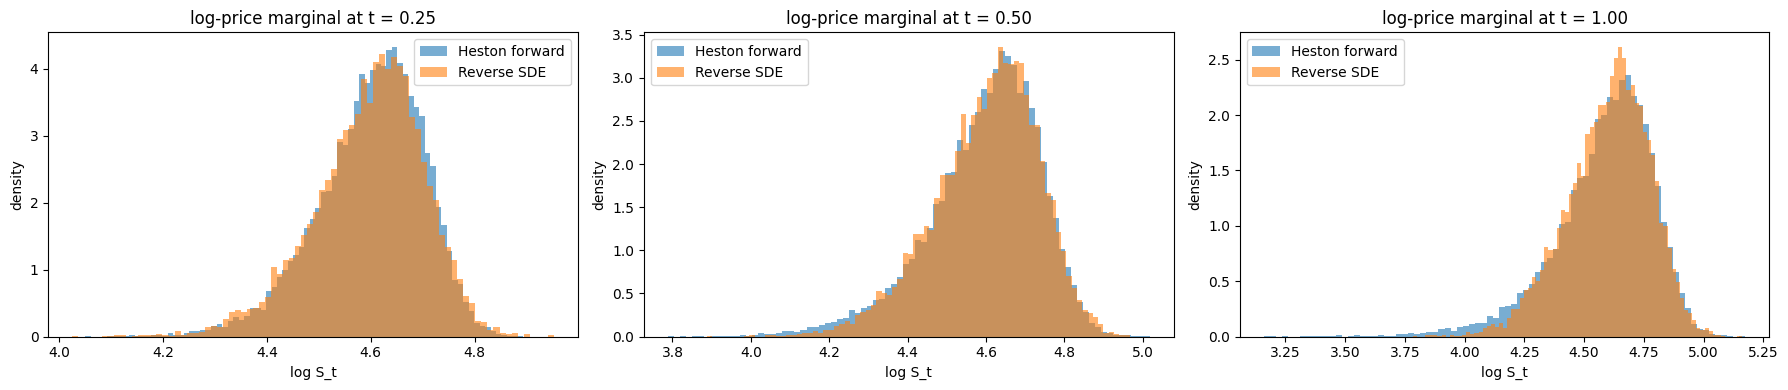

In [12]:
# 1) simulate Heston paths
n_paths_train = 20000
print("Simulating Heston paths...")
X_paths, V_paths = simulate_heston_paths(
    n_paths=n_paths_train,
    n_steps=n_steps,
    T=T_final,
    S0=S0,
    v0=v0,
    r=r,
    kappa=kappa,
    theta=theta,
    sigma_v=sigma_v,
    rho=rho,
)

# 2) build dataset using t in {0.25, 0.5, 1.0}
idx_025 = int(0.25 * n_steps)
idx_050 = int(0.5 * n_steps)
idx_100 = n_steps
t_indices = [idx_025, idx_050, idx_100]

dataset = HestonScoreDataset(X_paths, V_paths, t_indices, T_total=T_final)
print("Dataset size:", len(dataset))
print("x_mean/std:", dataset.x_mean.item(), dataset.x_std.item())
print("v_mean/std:", dataset.v_mean.item(), dataset.v_std.item())

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# 3) initialize model & optimizer
model = ScoreNet(hidden_dim=hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 4) training
print("Training score network...")
for epoch in range(1, n_epochs + 1):
    model.train()
    running_loss = 0.0
    for x_batch, t_batch in loader:
        x_batch = x_batch.to(device)
        t_batch = t_batch.to(device)

        optimizer.zero_grad()
        loss = dsm_loss(model, x_batch, t_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x_batch.size(0)

    avg_loss = running_loss / len(dataset)
    print(f"Epoch {epoch:03d}/{n_epochs}  loss = {avg_loss:.4f}")

print("Training done.")

# 5) evaluation
times_eval = [0.25, 0.50, 1.00]
idx_map = {0.25: idx_025, 0.50: idx_050, 1.00: idx_100}

n_samples_gen = 10000

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for i, t_phys in enumerate(times_eval):
    ax = axes[i]
    idx = idx_map[t_phys]

    X_forward = X_paths[:, idx].numpy()

    samples = annealed_langevin_sampling(
        model,
        n_samples=n_samples_gen,
        t_phys=t_phys,
        dataset=dataset,
        n_sigmas=n_sigmas,
        n_steps_each=n_langevin_steps_per_sigma,
        eps=langevin_eps,
        device=device,
    )
    X_gen = samples[:, 0].numpy()

    print(f"\n=== t = {t_phys:.2f} ===")
    print(f"Forward  mean/std: {X_forward.mean():.4f} / {X_forward.std():.4f}")
    print(f"Reverse   mean/std: {X_gen.mean():.4f} / {X_gen.std():.4f}")

    bins = 80
    ax.hist(X_forward, bins=bins, density=True, alpha=0.6, label="Heston forward")
    ax.hist(X_gen, bins=bins, density=True, alpha=0.6, label="Reverse SDE")
    ax.set_xlabel("log S_t")
    ax.set_ylabel("density")
    ax.set_title(f"log-price marginal at t = {t_phys:.2f}")
    ax.legend()

plt.tight_layout()
plt.show()

